In [1]:
import pandas as pd

# Load the dataset from the newly uploaded file
file_path = 'merged_dataset (3).csv'
data = pd.read_csv(file_path)

# Check the structure of the data
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   State                                           54 non-null     object 
 1   Urban_Percentage                                51 non-null     float64
 2   Total_Population                                51 non-null     float64
 3   Housing_Units                                   51 non-null     float64
 4   Population_Half                                 51 non-null     float64
 5   Low_Income_Half                                 51 non-null     float64
 6   Vehicle_Half                                    51 non-null     float64
 7   Population_1                                    51 non-null     float64
 8   Low_Income_1                                    51 non-null     float64
 9   Vehicle_1                                    

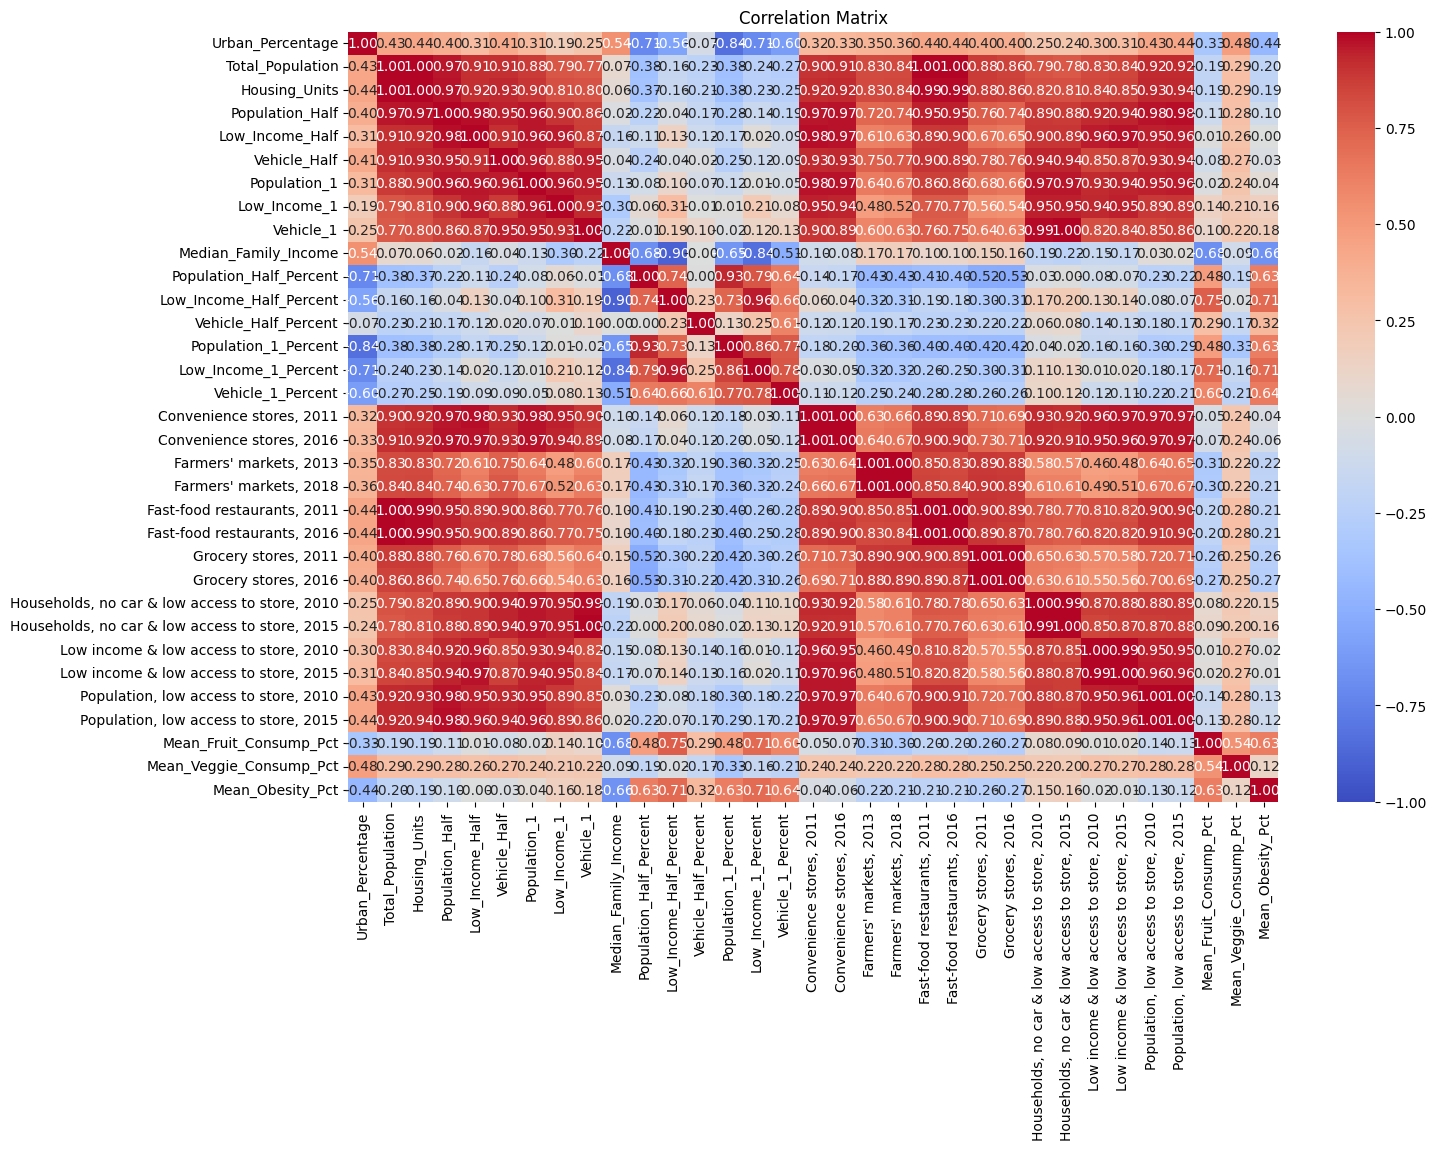

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop columns that are not relevant or have too many missing values
relevant_data = data.drop(columns=['State', 'Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0'])

# Calculate the correlation matrix
corr_matrix = relevant_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


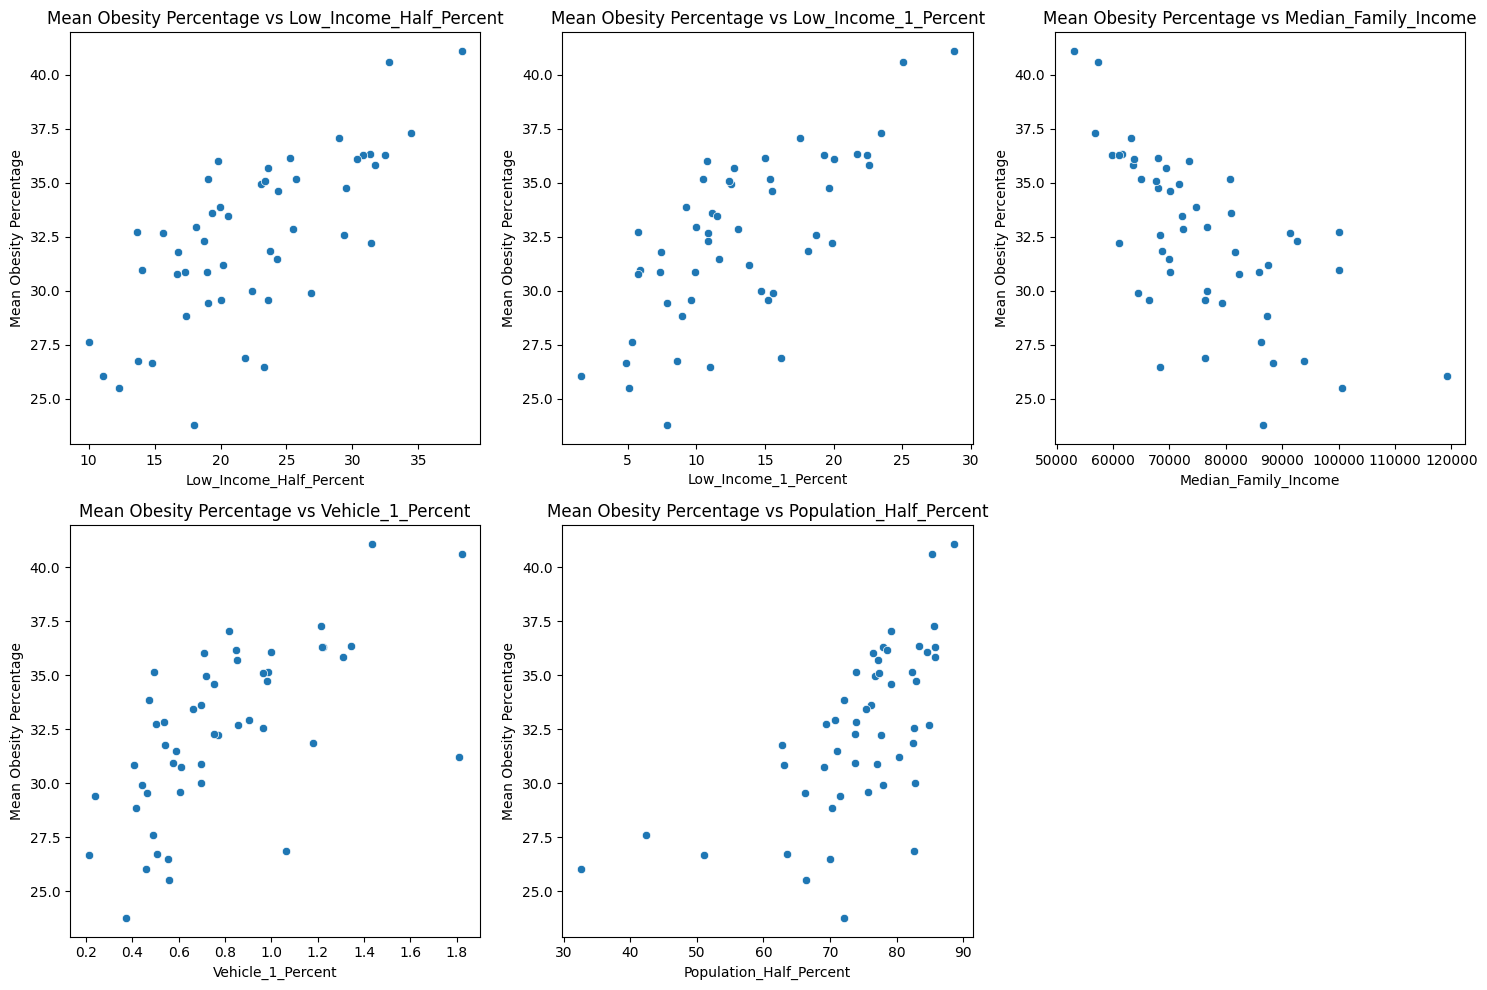

In [3]:
# Identify top correlated variables with mean obesity percentage
top_corr_vars = corr_matrix['Mean_Obesity_Pct'].abs().sort_values(ascending=False).index[1:6]

# Create scatter plots for the top correlated variables
plt.figure(figsize=(15, 10))

for i, var in enumerate(top_corr_vars, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=relevant_data, x=var, y='Mean_Obesity_Pct')
    plt.title(f'Mean Obesity Percentage vs {var}')
    plt.xlabel(var)
    plt.ylabel('Mean Obesity Percentage')

plt.tight_layout()
plt.show()


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Step 1: Define Treatment and Control Groups
# Create a binary treatment indicator based on median split
data['Treatment'] = (data['Low income & low access to store, 2015'] > data['Low income & low access to store, 2015'].median()).astype(int)

# Select relevant variables and drop rows with missing values
psm_data = data[['Low income & low access to store, 2010',
                 'Low income & low access to store, 2015',
                 'Population, low access to store, 2010',
                 'Population, low access to store, 2015',
                 'Median_Family_Income', 'Mean_Fruit_Consump_Pct',
                 'Mean_Veggie_Consump_Pct', 'Mean_Obesity_Pct', 'Treatment']].dropna()

# Step 2: Estimate Propensity Scores
X = psm_data.drop(columns=['Mean_Obesity_Pct', 'Treatment'])
y = psm_data['Treatment']

# Standardize the covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic regression to estimate propensity scores
logit = LogisticRegression()
logit.fit(X_scaled, y)
psm_data['Propensity_Score'] = logit.predict_proba(X_scaled)[:, 1]

# Step 3: Match Observations
# Using nearest-neighbor matching on propensity scores
treatment = psm_data[psm_data['Treatment'] == 1]
control = psm_data[psm_data['Treatment'] == 0]

nbrs = NearestNeighbors(n_neighbors=1).fit(control[['Propensity_Score']])
distances, indices = nbrs.kneighbors(treatment[['Propensity_Score']])

# Get matched control observations
matched_control = control.iloc[indices.flatten()]

# Combine treatment and matched control
matched_data = pd.concat([treatment, matched_control])
matched_data = matched_data[['Mean_Obesity_Pct', 'Treatment']]

# Step 4: Estimate Treatment Effect
# Calculate the difference in obesity rates between treatment and control groups
treatment_effect = matched_data.groupby('Treatment')['Mean_Obesity_Pct'].mean()
treatment_effect_difference = treatment_effect[1] - treatment_effect[0]
treatment_effect, treatment_effect_difference


(Treatment
 0    36.139372
 1    32.912685
 Name: Mean_Obesity_Pct, dtype: float64,
 -3.226686782353454)

Propensity Score Matching Results

Mean Obesity Percentage:

Control Group (Treatment = 0): 36.14%

Treatment Group (Treatment = 1): 32.91%

Estimated Treatment Effect:

The difference in mean obesity percentage between the treatment and control groups is approximately -3.23%.

Interpretation:

The propensity score matching suggests that areas with higher "Low income & low access to store, 2015" have a lower mean obesity percentage by approximately 3.23 percentage points, after accounting for the covariates.